In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import sklearn
from random import randrange

In [27]:
data = pd.read_csv('health_data.csv')
data.head()

,age,restbps,chol,category
0,26,109,243,0
1,27,106,156,0
2,28,107,225,0
3,27,105,277,0
4,30,96,221,0


In [28]:
X = data.to_numpy()[:, :]

In [29]:
##k-Cross_validation_split:
def cross_validation_split(dataset,k):
    k_folds = list()
    copy_data = list(dataset)
    fold_size = int(len(dataset)/k)
    
    for i in range(k):
        fold = list()
        for j in range(fold_size):
            fold.append(copy_data.pop(randrange(len(copy_data))))
        k_folds.append(fold)
    return k_folds    

In [5]:
X = data.to_numpy()[:, :3]
Y = data.to_numpy()[:, 3]
split = 0.8 #using 70:30 split, random each time
train_samples = np.random.choice(X.shape[0], int(split*X.shape[0]))
test_samples = np.array([i for i in range(X.shape[0]) if i not in list(train_samples)])

X_train = X[[train_samples]]
Y_train = Y[[train_samples]]

X_test = X[[test_samples]]
Y_test = Y[[test_samples]]


X_0 = X_train[Y_train == 0]
X_1 = X_train[Y_train == 1]



X_test_0 = X_test[Y_test == 0]
X_test_1 = X_test[Y_test==1]


E:\Anaconda\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  import sys
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  

# Naive_Bayes_Classifier_with_Gaussian_Prior

In [30]:
#mean function
def mean(data):
    return sum(data)/float(len(data))

In [31]:
#variance function
def std(data):
    mu  = mean(data)
    return math.sqrt(sum([(x - mu)**2 for x in data])/float(len(data) - 1))

In [32]:
#stat of class 0(Maximum Likelihood Estimate)
def statistics_0(X_0):
    stat_X0 = [(mean(col),  std(col)) for col in zip(*X_0)]
    return stat_X0

In [33]:
#stat of class 1(Maximum Likelihood Estimate)
def statistics_1(X_1):
    stat_X1 = [(mean(col),  std(col)) for col in zip(*X_1)]
    return stat_X1

In [34]:
def statistics(X_class):
    stat_X_class = [(mean(col),  std(col)) for col in zip(*X_class)]
    return stat_X_class

In [35]:
stat = [statistics(X_0), statistics(X_1)]

In [36]:
#Probability calculation
def Normal_dist(x, mean, std):
    return (1 / (math.sqrt(2 * math.pi) * std)) *math.exp(-((x-mean)**2 / (2 * std**2 )))

In [37]:
#prior calculation
def prior(X_0, X_1):
    P = [float(len(X_0))/ float(len(X_0) + len(X_1)) ,float(len(X_1))/ float(len(X_0) + len(X_1)) ]
    return P

In [38]:
P = prior(X_0, X_1)

In [39]:
def prior_multi_class(X, no_of_classes):
    P = []
    for i in range(no_of_classes):
        P.append(float(X[X[:, -1] == i].shape(1)/X.shape(1)))
    return P

In [40]:
#calculation of class conditional density
def class_conditional_probability(data, stat, no_of_classes):
    probabilities = np.ones(no_of_classes, dtype = np.float64)
    for i in range(no_of_classes):
        for j in range(len(stat[i])):
            mean, stdev = stat[i][j]
            #print( Normal_dist(data[i], mean, stdev))
            probabilities[i] *= Normal_dist(data[j], mean, stdev)
    return probabilities

In [41]:
#calculation of posterior
def posterior(data, stat, P, no_of_classes):
    prob = np.zeros(no_of_classes, dtype = np.float64)
    probabilities = class_conditional_probability(data, stat, no_of_classes)
    #print(probabilities)
    for i in range(no_of_classes):
        prob[i] = probabilities[i]*P[i]
    return prob

In [42]:
def prediction(data, stat,P, Th, no_of_classes):
    Probabilities = posterior(data, stat, P, no_of_classes)
    Probabilities = Probabilities/sum(Probabilities)
    #print(Probabilities)
    if Probabilities[1] > Th:
        return 1
    else:
        return 0

In [43]:
def prediction_multi_class(data, stat,P, Th, no_of_classes):
    Probabilities = posterior(data, stat, P)
    Probabilities = Probabilities/sum(Probabilities)
    #print(Probabilities)
    y_prediction = np.zeros(no_of_classes)
    y_prediction[np.argmax(np.array(Probabilities))] = 1
    return y_prediction

100%|██████████| 1000/1000 [00:50<00:00, 19.69it/s]


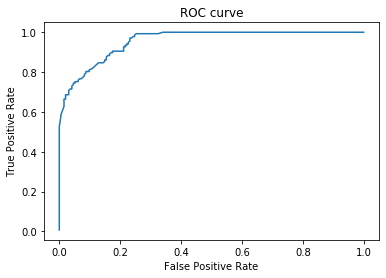

In [19]:
from tqdm import tqdm
TP = []
FP = []
accuracy = []
precision = []
recall = []
f1_score = []
no_of_classes = 2
for p0 in tqdm(np.linspace(0.000000001,0.999999999999,1000)):
    C = np.zeros((2,2)) #[[]]
    for i in range((X_test_0.shape[0])):
        y_pred = prediction(X_test_0[i], stat, P, p0, no_of_classes)
        C[y_pred, 0] += 1
    for i in range((X_test_1.shape[0])):
        y_pred = prediction(X_test_1[i], stat, P, p0,no_of_classes)
        C[y_pred, 1] += 1
    
    tpr = C[1,1]/(C[1,1] + C[0,1])
    fpr = C[1,0]/(C[1,0] + C[0,0])
    acc = (C[0,0] + C[1,1])/np.sum(C) 
    pr = C[1,1]/(C[1,1] + C[1,0])
    rec = C[1,1]/(C[1,1] + C[0,1])
    f1 = 2*(pr*rec)/(pr + rec)
    precision.append(pr)
    recall.append(rec)
    f1_score.append(f1)
    accuracy.append(acc)
    TP.append(tpr)
    FP.append(fpr)

plt.plot(FP, TP, '-')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC curve');

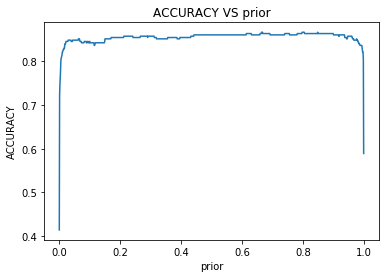

In [20]:
plt.plot(np.linspace(0.000000001,0.999999999999,1000), accuracy, '-')
plt.xlabel('prior'); plt.ylabel('ACCURACY'); plt.title('ACCURACY VS prior');

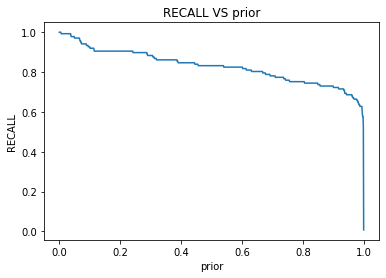

In [21]:
plt.plot(np.linspace(0.000000001,0.999999999999,1000), recall, '-')
plt.xlabel('prior'); plt.ylabel('RECALL'); plt.title('RECALL VS prior');

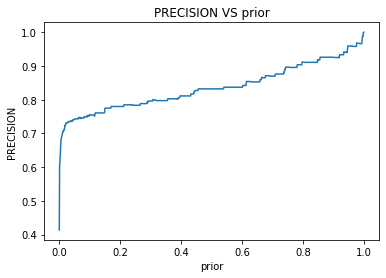

In [22]:
plt.plot(np.linspace(0.000000001,0.999999999999,1000), precision, '-')
plt.xlabel('prior'); plt.ylabel('PRECISION'); plt.title('PRECISION VS prior');

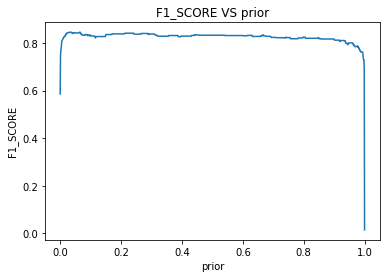

In [23]:
plt.plot(np.linspace(0.000000001,0.999999999999,1000), f1_score, '-')
plt.xlabel('prior'); plt.ylabel('F1_SCORE'); plt.title('F1_SCORE VS prior');

# k-fold evaluation

In [ ]:
from tqdm import tqdm

In [65]:
def k_fold_evaluation(dataset, no_of_folds):
    k_folds = cross_validation_split(dataset, no_of_folds)
    accuracy_list = []
    TP_rate_list = []
    FP_rate_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    ind = 0
    for fold in k_folds:
        
        X_train = list(k_folds)
        #print(ind)
        del X_train[ind]
        ind=ind+1
        X_train = sum(X_train, [])
        X_train = np.array(X_train)
        X_0 = X_train[X_train[:,3] == 0]
        X_1 = X_train[X_train[:,3] == 1]
        stat = [statistics_0(X_0[:,:3]),statistics_1(X_1[:,:3])]
        fold = np.array(fold)
        X_test_0 = fold[fold[:,3] == 0]
        X_test_1 = fold[fold[:,3] == 1]
        P = prior(X_0, X_1)
        for i in range((X_test_0.shape[0])):
            y_pred = prediction(X_test_0[i], stat, P, 0.5,2)
            C[y_pred, 0] += 1
        for i in range((X_test_1.shape[0])):
            y_pred = prediction(X_test_1[i], stat, P, 0.5,2)
            C[y_pred, 1] += 1
        acc = (C[0,0] + C[1,1])/np.sum(C) 
        pr = C[1,1]/(C[1,1] + C[1,0])
        rec = C[1,1]/(C[1,1] + C[0,1])
        f1 = 2*(pr*rec)/(pr + rec)
        accuracy_list.append(acc)
        precision_list.append(pr)
        recall_list.append(rec)
        f1_score_list.append(f1)
    return np.mean(np.array(accuracy_list)), np.mean(np.array(TP_rate_list)), np.mean(np.array(FP_rate_list)), np.mean(np.array(precision_list)), np.mean(np.array(recall_list)), np.mean(np.array(f1_score_list)) 
    

In [66]:
accuracy_list, TP_rate_list, FP_rate_list, precision_list, recall_list, f1_score_list = k_fold_evaluation(X, 5)
print(accuracy_list)
print(precision_list)
print(recall_list)
print(f1_score_list)

0.845844980804662
0.8378294690586664
0.7926633425386136
0.8146204855868703


In [71]:
accuracy = []
precision = []
recall = []
f1_score = []
for k in range(2,40):
    accuracy_list, TP_rate_list, FP_rate_list, precision_list, recall_list, f1_score_list = k_fold_evaluation(X, k)
    #print("for " + str(k) + " fold results of evaluation metric")
    #print(accuracy_list)
    #print(precision_list)
    #print(recall_list)
    #print(f1_score_list)
    accuracy.append(accuracy_list)
    precision.append(precision_list)
    recall.append(recall_list)
    f1_score.append(f1_score_list)

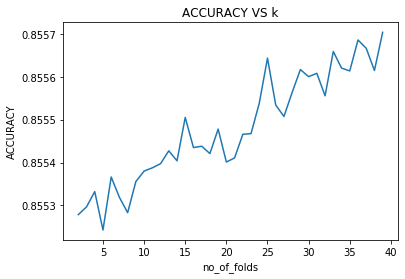

In [83]:
plt.plot(range(2,40), accuracy, '-')
plt.xlabel('no_of_folds'); plt.ylabel('ACCURACY'); plt.title('ACCURACY VS k');

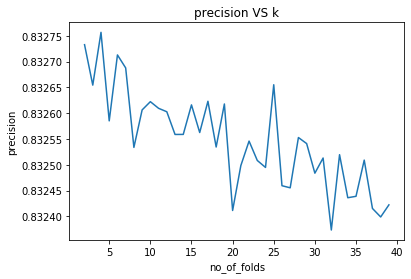

In [84]:
plt.plot(range(2,40), precision, '-')
plt.xlabel('no_of_folds'); plt.ylabel('precision'); plt.title('precision VS k');

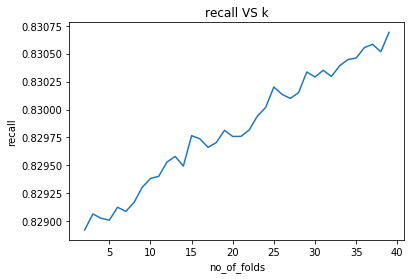

In [85]:
plt.plot(range(2,40), recall, '-')
plt.xlabel('no_of_folds'); plt.ylabel('recall'); plt.title('recall VS k');

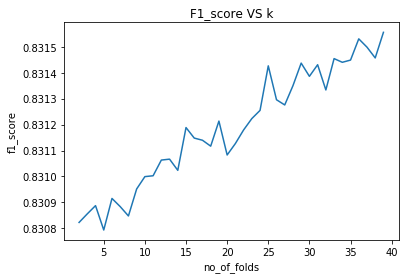

In [86]:
plt.plot(range(2,40), f1_score, '-')
plt.xlabel('no_of_folds'); plt.ylabel('f1_score'); plt.title('F1_score VS k');

## question 3

In [25]:
import os
IMAGE_PATH = './Medical_MNIST'
print(os.path.abspath(IMAGE_PATH))
n_components = 20

C:\Users\rockt\Assignment1_git\ELL409_Assignment1\Medical_MNIST
